In [36]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import joblib


In [37]:
# Load and Clean Dataset
df = pd.read_csv('keypoints.csv', header=0)
df = df.dropna()

X = df.iloc[:, :-1].astype(np.float32)
y = df.iloc[:, -1].astype(str)


In [38]:
# Normalize keypoints
def normalize(row):
    coords = row.values.reshape(-1, 2)
    coords -= coords[0]
    max_val = np.max(np.abs(coords))
    return (coords / max_val).flatten() if max_val != 0 else coords.flatten()

X_normalized = X.apply(normalize, axis=1, result_type='expand')


In [39]:
# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_cat = to_categorical(y_encoded)
joblib.dump(le, 'label_encoder.pkl')

# Split data
X_train, X_val, y_train, y_val = train_test_split(
    X_normalized, y_cat, test_size=0.2, stratify=y_cat, random_state=42
)

# Class weights
class_weights = class_weight.compute_class_weight(
    'balanced', classes=np.unique(y_encoded), y=y_encoded
)
class_weights_dict = dict(enumerate(class_weights))


In [40]:

# Build Model
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(y_cat.shape[1], activation='softmax'))

# Compile
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


c:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(len(np.unique(y_train)), activation='softmax')
])


c:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [42]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

optimizer = Adam(learning_rate=0.001)

lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=1)

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=150,
    batch_size=32,
    class_weight=class_weights_dict,
    callbacks=[early_stop, checkpoint, lr_schedule],
    verbose=1
)

model.save('final_model.keras')


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - accuracy: 0.1237 - loss: 3.2821 - val_accuracy: 0.1005 - val_loss: 2.7235
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.3367 - loss: 2.2162 - val_accuracy: 0.1005 - val_loss: 2.7235
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6126 - loss: 1.5777 - val_accuracy: 0.1005 - val_loss: 2.7323
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7135 - loss: 1.2501 - val_accuracy: 0.1005 - val_loss: 2.7340
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7880 - loss: 1.0592 - val_accuracy: 0.1461 - val_loss: 2.7069
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8414 - loss: 0.8663 - val_accuracy: 0.1553 - val_loss: 2.6364
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8690 - loss: 0.7991 - val_accuracy: 0.2785 - val_loss: 2.5567
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9010 - loss: 0.7030 - val_accuracy: 

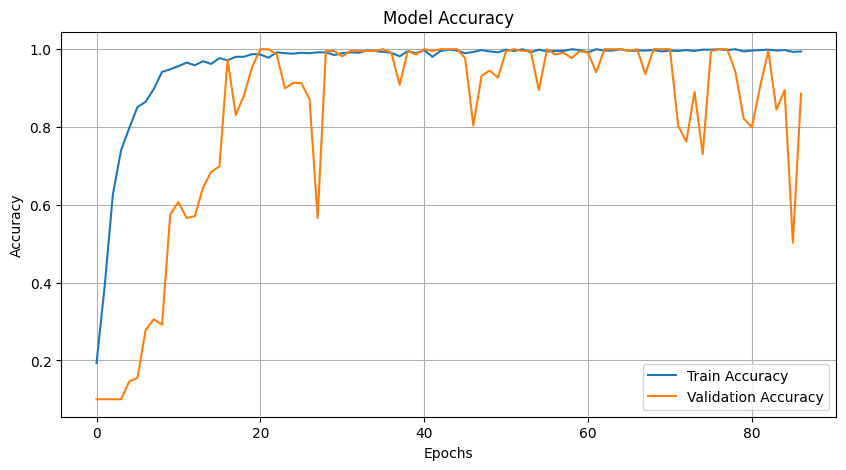

In [47]:
# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [44]:
# Classification report
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

print("Classification Report:")
report = classification_report(y_true_classes, y_pred_classes, target_names=le.classes_)
print(report)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        11
          10       1.00      1.00      1.00        21
           2       1.00      1.00      1.00        22
           3       1.00      1.00      1.00        20
           4       1.00      1.00      1.00        20
           5       1.00      1.00      1.00        26
           6       1.00      1.00      1.00        25
           7       1.00      1.00      1.00        25
           8       1.00      1.00      1.00        20
           9       1.00      1.00      1.00        29

    accuracy                           1.00       219
   macro avg       1.00      1.00      1.00       219
weighted avg       1.00      1.00      1.00       219



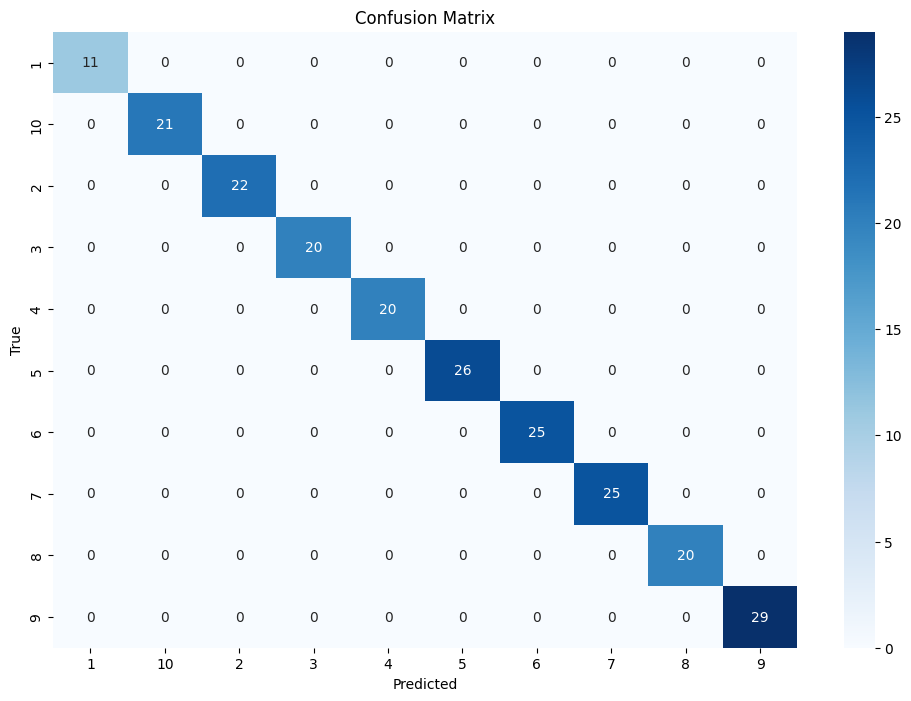

In [49]:
# Confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
